# Intro To AI Final Project

## Libraries from Open AI Gymnasium

In [1]:
import gymnasium as gym  #gym environment so I can run the humanoid environment
import numpy as np
from stable_baselines3 import PPO  #built in reinforcement learning model 
from stable_baselines3.common.vec_env import DummyVecEnv  #additional library for PPO to work correctly
from stable_baselines3.common.monitor import Monitor #keeps track of the rewards and lengths for training
import imageio  #to save a video of the humanoid

## Random Agent

In [2]:
def run_random_agent(num_episodes=5, max_steps=1000):
    env = gym.make("Humanoid-v5")  #creates the humanoid environment from openAI gym
    episode_rewards = [] #these listes store the results of how the random agend does each turn through
    episode_lengths = []

    for ep in range(num_episodes):  #runs the random agent amount of episodes (aka attempts) we set
        obs, info = env.reset() #sets the environment to the starting state
        total_reward = 0.0  #keeps track of the agents points
        length = 0  #counts the amound of steps the agent succeeded

        for t in range(max_steps):   #loops through each step of the episodes
            action = env.action_space.sample()  #picks a randome action from the action space
            
            result = env.step(action) #stores the information for what happens each step
            obs = result[0]  #the state of the humanoid after doing the action
            reward = result[1]  #the amount of points the action earned
            terminated = result[2]  #true if the humanoid dint fal
            truncated = result[3]  #true if the episode hit the max steps
            info = result[4]  
            
            total_reward += reward  #adding reward from this step to total reward
            length += 1  #adds a count to the amount of steps taken

            if terminated or truncated: #stop if the humanoid runs out of time or fails
                break

        episode_rewards.append(total_reward)  #stores total rewards for this epi
        episode_lengths.append(length)  #stores how long the epi lasted

    env.close()  #closes the humanoid environment
    
    print("\nRandom agent summary:")  #prints the average of the random attempts
    print(f"  Mean reward: {np.mean(episode_rewards):.2f}")
    print(f"  Mean length: {np.mean(episode_lengths):.1f}")

run_random_agent()


Random agent summary:
  Mean reward: 114.43
  Mean length: 24.4


## Humanoid Environment using PPO

In [3]:
def make_env():
    def _init():
        env = gym.make("Humanoid-v5")  #creates the humanoid environment
        env = Monitor(env)  #keeps track of the episode rewards & lengths
        return env
    return _init

vec_env = DummyVecEnv([make_env()]) #using a specific environment bc "PPO is meant to be run primarily on the CPU, especially when you are not using a CNN" from resource 3

model = PPO(  #proximal policy optimization model from stable baselines 
    "MlpPolicy", #using a mlp neural network as its the default for the gymnasium humanoid
    vec_env,
    verbose=1,

    #these are the parameters for this model, haven't gotten into hyperparameter tuning much so will stick with the default
    n_steps=2048,
    batch_size=64,
    learning_rate=3e-4,
    gamma=0.99,
)

model.learn(total_timesteps=1_500_000)  #this is how we control hoow many training steps the model takes, more is better for the goal
model.save("ppo_humanoid_v5")  #saves the trained humanoid model

Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.7     |
|    ep_rew_mean     | 96       |
| time/              |          |
|    fps             | 577      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 22.9        |
|    ep_rew_mean          | 102         |
| time/                   |             |
|    fps                  | 503         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.020275684 |
|    clip_fraction        | 0.237       |
|    clip_range           | 0.2         |
|    entropy_loss         | -24.1       |
|    explained_variance   | -0.00268    |
|    learning

## Evaluate the Reinforcement Learning Performance

In [4]:
def evaluate_ppo(model, num_episodes=100, max_steps=1000):
    env = gym.make("Humanoid-v5")  #creates the humanoid environment
    rewards = []   #stores total reward for each PPO attempt
    lengths = []   #store # steps the humanoid survived

    for ep in range(num_episodes): #loops through the PPO agent for as many as we set it to
        obs, info = env.reset() #starts the environment from the beginning each time
        total_reward = 0.0  #keeps track of the points earned each episode
        length = 0  #counts the amount of steps the episode lasts

        for t in range(max_steps):  #loops through each episode step
            action, _ = model.predict(obs, deterministic=True)  #the trained ppo model pics the action
            result = env.step(action) #stores the information for what happens each step
            obs = result[0]  #the state of the humanoid after doing the action
            reward = result[1]  #the amount of points the action earned
            terminated = result[2]  #true if the humanoid dint fal
            truncated = result[3]  #true if the episode hit the max steps
            info = result[4]  #stores extra info
            total_reward += reward
            length += 1

            if terminated or truncated: #stops if we hit a time limit or the humanoid fails
                break

        rewards.append(total_reward)  #stores the episode reward
        lengths.append(length)  #stores teh timelength of the episode

    env.close()  #closes the humanoid environment

    return rewards, lengths   #returns these values for plotting

In [5]:
import matplotlib.pyplot as plt

def plot_rewards(rewards):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards, color = 'green')  #plots the rewards across all the episodes
    plt.title('PPO Total Rewards per Episode') 
    plt.xlabel('Episode Number')
    plt.ylabel('Total Reward')
    plt.grid(True)

    plt.savefig(r"C:\Users\Bri\Pictures\Humanoid_1,500,000.png", dpi=300) #saves graph to computer
    
    plt.show()

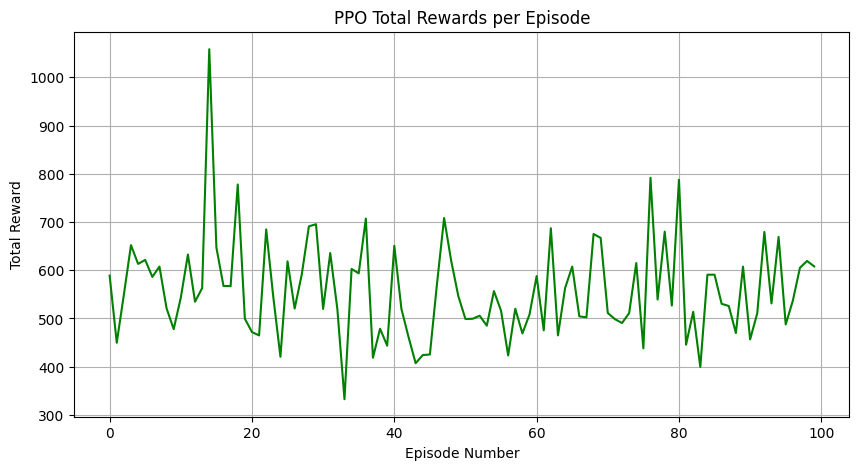

In [6]:
model = PPO.load("ppo_humanoid_v5", env=vec_env)  #loads the trained ppo model

ppo_rewards, ppo_lengths = evaluate_ppo(model)  #runs the ppo model for the amount of episodes we set

plot_rewards(ppo_rewards)  #makes a plot of the rewards across episodes

## Saves the Humanoid Video

In [7]:
def record_ppo_video(model, filename="humanoid_ppo.gif",
                     max_steps=2000, episode_horizon=1000):
    env = gym.make("Humanoid-v5", render_mode="rgb_array")  #makes the humanoid environment for RGB frames
    obs, info = env.reset()
    frames = []  #stores the video frames
    steps = 0

    while steps < max_steps:
        action, _ = model.predict(obs, deterministic=True)  #these steps move through the models actions
        obs, reward, terminated, truncated, info = env.step(action)

        frame = env.render()   #gets each frame at a time and stores it
        frames.append(frame)

        steps += 1
        if terminated or truncated:  #if the humanoid fails it stops at this motion or frame
            obs, info = env.reset()

    env.close()
    print(f"Saving {len(frames)} frames to {filename} ...")
    imageio.mimsave(filename, frames, fps=30)  #saves the environment as a GIF

model = PPO.load("ppo_humanoid_v5", env=vec_env)  #takes the saved model and loads to memory
filename=r"C:\Users\Bri\Videos\humanoid_ppo_long.gif"
record_ppo_video(model, r"C:\Users\Bri\Videos\humanoid_ppo_long.gif") #saves the video to my computer as a GIF


Saving 2000 frames to C:\Users\Bri\Videos\humanoid_ppo_long.gif ...
